In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# Define the repository URL and the local directory where you want to clone/pull the repository
repo_url = 'https://github.com/aakashvardhan/s11-gradcam.git'
local_dir = '/content/s11-gradcam'



# Check if the local directory already exists
if not os.path.exists(local_dir):
    # Clone the repository because it does not exist
    !git clone {repo_url}
else:
    # Change directory to the local repository
    %cd {local_dir}
    # Pull the latest changes because the repository already exists
    !git pull

Cloning into 's11-gradcam'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 50 (delta 15), reused 43 (delta 10), pack-reused 0
Receiving objects: 100% (50/50), 15.27 KiB | 15.27 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [3]:
import sys
sys.path.append('/content/s11-gradcam')
sys.path.append('/content/s11-gradcam/models')
sys.path.append('/content/s11-gradcam/utils')

In [4]:
!pip install torch-lr-finder

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [5]:
from config import get_config
config = get_config()
from main import main,set_seeds,setup_cifar10
import torch
from torch_lr_finder import LRFinder
from models.resnet import ResNet18
from models.model_utils import model_summary, adam_optimizer
import torch.nn as nn
from trainer import ModelTrainer
from torch.optim.lr_scheduler import OneCycleLR
set_seeds()

In [6]:
config['epochs'] = 20
config['lr_scheduler'] = 'one_cycle'
config['lr'] = 0.001

In [7]:
train_data, test_data, train_loader, test_loader = setup_cifar10(config)

CUDA Available? True


100%|██████████| 170498071/170498071 [00:13<00:00, 13102140.09it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
device = config["device"]
model = ResNet18().to(device)
model_summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = adam_optimizer(model, config)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.10E-03


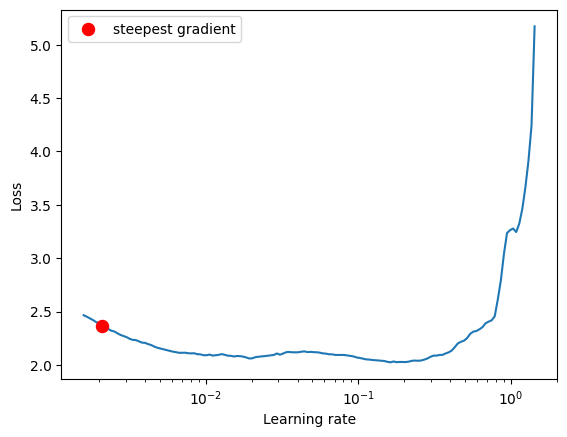

In [11]:
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot()  # to inspect the loss-learning rate graph
lr_finder.reset()

In [12]:
ocp_scheduler = OneCycleLR(
        optimizer,
        max_lr=2.10E-03,
        steps_per_epoch=len(train_loader),
        epochs=config["epochs"],
        pct_start=5 / config["epochs"],
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy="linear")

In [13]:
# Create an instance of the ModelTrainer class
trainer = ModelTrainer(model, device, train_loader, test_loader, optimizer, criterion, ocp_scheduler)

In [14]:
lr = main(config,model,trainer)

EPOCH: 1


  0%|          | 0/391 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Loss=1.3299800157546997 Batch_id=390 Accuracy=39.88: 100%|██████████| 391/391 [00:50<00:00,  7.76it/s]

Max Learning Rate: 0.0004370127942681678



Test set: Average loss: -3.5870, Accuracy: 4434/10000 (44.34%)

EPOCH: 2


Loss=1.0045512914657593 Batch_id=390 Accuracy=57.25: 100%|██████████| 391/391 [00:49<00:00,  7.88it/s]

Max Learning Rate: 0.0008530255885363355



Test set: Average loss: -4.7557, Accuracy: 6259/10000 (62.59%)

EPOCH: 3


Loss=0.8947468996047974 Batch_id=390 Accuracy=65.61: 100%|██████████| 391/391 [00:49<00:00,  7.84it/s]

Max Learning Rate: 0.0012690383828045033



Test set: Average loss: -5.3689, Accuracy: 6549/10000 (65.49%)

EPOCH: 4


Loss=0.8408676981925964 Batch_id=86 Accuracy=68.74:  22%|██▏       | 87/391 [00:11<00:39,  7.69it/s]


KeyboardInterrupt: 